In [7]:
from self_supervised.pipelines.representation_model import RepresentationModel, YoloEncoder
from yolov5.models.yolo import DetectionModel
import torch

%reload_kedro
model_description = catalog.load("yolov5_l_description")
trained_model = catalog.load("trained_model")

# Random model
#encoder = YoloEncoder(model_description=model_description)
#trained_model = RepresentationModel(encoder=encoder)

# CoCO model
model_description["head"] = model_description["head"][:-1]
trained_model = DetectionModel(model_description)
weights_model = torch.load("../yolov5l.pt", map_location="cpu")
state_dict = weights_model["model"].float().state_dict()
trained_model.load_state_dict(state_dict, strict=False)

trained_model = trained_model.eval()

2023-03-09 10:08:15,162 - kedro.ipython - INFO - Resolved project path as: /home/daniel/git/self-supervised-learning.
To set a different path, run '%reload_kedro <project_root>'
2023-03-09 10:08:15,163 - py.warnings - WARNING - /home/daniel/git/self-supervised-learning/.venv/lib/python3.10/site-packages/kedro/framework/startup.py:98: DeprecationWarning: project_version in pyproject.toml is deprecated, use kedro_init_version instead
  warnings.warn(

2023-03-09 10:08:15,273 - kedro.ipython - INFO - Kedro project Self-Supervised Learning
2023-03-09 10:08:15,274 - kedro.ipython - INFO - Defined global variable 'context', 'session', 'catalog' and 'pipelines'
2023-03-09 10:08:15,279 - kedro.io.data_catalog - INFO - Loading data from 'yolov5_l_description' (YAMLDataSet)...
2023-03-09 10:08:15,284 - kedro.io.data_catalog - INFO - Loading data from 'trained_model' (PytorchModelDataSet)...


2023-03-09 10:08:15.284 | WARNING  | self_supervised.extras.datasets.pytorch_model_data_set:_load:42 - CUDA not available, automatically mapping variables to the CPU.

                 from  n    params  module                                  arguments                     
  0                -1  1      7040  yolov5.models.common.Conv               [3, 64, 6, 2, 2]              
  1                -1  1     73984  yolov5.models.common.Conv               [64, 128, 3, 2]               
  2                -1  3    156928  yolov5.models.common.C3                 [128, 128, 3]                 
  3                -1  1    295424  yolov5.models.common.Conv               [128, 256, 3, 2]              
  4                -1  6   1118208  yolov5.models.common.C3                 [256, 256, 6]                 
  5                -1  1   1180672  yolov5.models.common.Conv               [256, 512, 3, 2]              
  6                -1  9   6433792  yolov5.models.common.C3                 [512, 5

In [9]:
from pathlib import Path

dataset_path = Path("/home/daniel/lab_share/projects/CottonFlower2021/flower_dataset")
image_dir = dataset_path / "flower01" / "images"

In [24]:
from torchvision.io import read_image
from torchvision.transforms.functional import resize
from tqdm import tqdm
import torch

image_reps = []

image_list = sorted(list(image_dir.iterdir()))
for image_path in tqdm(image_list):
    image = read_image(image_path.as_posix())
    image.requires_grad = False
    image = resize(image, (512, 512))
    image = image.to(torch.float) / 255
    image_ex = image[None, :, :, :]
    
    image_reps.append(trained_model(image_ex)[0].detach().reshape((1, -1)).numpy())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 458/458 [01:06<00:00,  6.90it/s]


In [25]:
# Load flower counts.
import pandas as pd

labels_dir = dataset_path / "flower01" / "labels"
all_labels = []
labels_list = sorted(list(labels_dir.iterdir()))
for labels_path in labels_list:
    frame_labels = pd.read_csv(labels_path, sep=" ", names=["class", "x", "y", "width", "height"])
    frame_labels["frame"] = labels_path.name
    all_labels.append(frame_labels)
    
all_labels = pd.concat(all_labels, ignore_index=True)
all_labels

,class,x,y,width,height,frame
0,0,0.635938,0.238889,0.020833,0.037037,000001.txt
1,0,0.379427,0.065278,0.015104,0.034259,000001.txt
2,0,0.634375,0.245370,0.020833,0.037037,000002.txt
3,0,0.379948,0.068981,0.015104,0.034259,000002.txt
4,0,0.379948,0.069907,0.015104,0.034259,000003.txt
...,...,...,...,...,...,...
1987,0,0.495833,0.971759,0.030208,0.052778,000383.txt
1988,0,0.496875,0.976852,0.030208,0.046296,000384.txt
1989,0,0.497656,0.980093,0.028646,0.037963,000385.txt
1990,0,0.497135,0.986111,0.028646,0.027778,000386.txt


In [26]:
import numpy as np

# Create flower counts labels.
flower_counts = []
for image_path in labels_list:
    flower_counts.append(np.count_nonzero(all_labels["frame"] == image_path.name))
    
# Any missing counts are zeros.
for _ in range(len(flower_counts), len(image_reps)):
    flower_counts.append(0)

In [27]:
test_image_dir = dataset_path / "flower02" / "images"

test_image_reps = []

image_list = sorted(list(test_image_dir.iterdir()))
for image_path in tqdm(image_list):
    image = read_image(image_path.as_posix())
    image.requires_grad = False
    image = resize(image, (512, 512))
    image = image.to(torch.float) / 255
    image_ex = image[None, :, :, :]
    
    test_image_reps.append(trained_model(image_ex)[0].detach().reshape((1, -1)).numpy())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 333/333 [00:48<00:00,  6.82it/s]


In [28]:
test_labels_dir = dataset_path / "flower02" / "labels"
all_labels_test = []
labels_list = sorted(list(test_labels_dir.iterdir()))
for labels_path in labels_list:
    frame_labels = pd.read_csv(labels_path, sep=" ", names=["class", "x", "y", "width", "height"])
    frame_labels["frame"] = labels_path.name
    all_labels_test.append(frame_labels)
    
all_labels_test = pd.concat(all_labels_test, ignore_index=True)
all_labels_test

,class,x,y,width,height,frame
0,0,0.407813,0.032870,0.014583,0.023148,000001.txt
1,0,0.408854,0.042130,0.014583,0.023148,000002.txt
2,0,0.408854,0.042130,0.014583,0.023148,000003.txt
3,0,0.408854,0.042130,0.014583,0.023148,000004.txt
4,0,0.408854,0.042130,0.014583,0.023148,000005.txt
...,...,...,...,...,...,...
1583,0,0.441406,0.814352,0.020313,0.036111,000287.txt
1584,0,0.437240,0.838426,0.020313,0.036111,000288.txt
1585,0,0.433073,0.858796,0.020313,0.036111,000289.txt
1586,0,0.434635,0.871759,0.011979,0.028704,000290.txt


In [29]:
# Create flower counts.
test_flower_counts = []
for image_path in labels_list:
    test_flower_counts.append(np.count_nonzero(all_labels_test["frame"] == image_path.name))
    
# Any missing counts are zeros.
for _ in range(len(test_flower_counts), len(test_image_reps)):
    test_flower_counts.append(0)

In [30]:
# Create combined dataset.
all_image_reps = image_reps + test_image_reps
all_flower_counts = flower_counts + test_flower_counts
train_indices = np.arange(len(image_reps))
test_indices = np.arange(len(image_reps), len(all_image_reps))

In [31]:
from sklearn.linear_model import RidgeCV

all_flower_counts = np.array(all_flower_counts, dtype=float)
all_image_reps_arr = np.concatenate(all_image_reps, axis=0)

alphas = [1e-6, 1e-4, 0.01, 0.1, 1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0]
reg = RidgeCV(alphas=alphas, cv=((train_indices, test_indices),)).fit(all_image_reps_arr, all_flower_counts)

2023-03-09 10:18:04,084 - py.warnings - WARNING - /home/daniel/git/self-supervised-learning/.venv/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(

2023-03-09 10:18:07,355 - py.warnings - WARNING - /home/daniel/git/self-supervised-learning/.venv/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(

2023-03-09 10:18:08,228 - py.warnings - WARNING - /home/daniel/git/self-supervised-learning/.venv/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=2.07901e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)

2023-03-09 10:18:08,740 - py.warnings - WARNING - /home/daniel/git/self-supervised-learning/.venv/lib/python3.10/site-packages/sklearn/

In [32]:
test_image_reps_arr = np.concatenate(test_image_reps, axis=0)
test_preds = reg.predict(test_image_reps_arr)
test_preds

array([     1.0128,      0.9918,      1.0032,      1.0098,     0.99642,     0.99263,      1.0116,      1.0042,     0.98511,        1.01,     0.99239,      1.0013,     0.99926,     0.99437,      1.0099,        1.01,      1.0158,      1.0016,      1.0159,     0.98782,      1.0047,      1.0259,      2.0111,      2.9686,
            2.9761,        2.98,      3.0643,      3.9655,      3.9838,      4.0036,      3.9918,      3.9902,      4.0096,      3.9935,       3.987,      3.9937,      3.0303,      2.9997,      3.0101,      2.9977,      3.0163,      2.9997,      3.0019,      3.0195,      3.9937,      4.9914,      5.9664,      5.9853,
            5.9637,      5.0278,      5.0143,       5.022,      5.0022,      5.9708,      5.9734,      5.0285,      4.9933,      5.0013,      5.0094,      4.9892,      5.0121,      5.0026,       4.993,      4.9783,      4.0464,      4.0622,      5.9405,      5.9922,      6.0144,      5.9817,      6.0039,      6.0026,
            5.9731,      6.0242,       6.975,      6.9819,      6.9896,      6.9979,      7.0062,      7.0041,      7.0164,      6.9886,      6.9821,      7.0239,      7.0022,      6.9831,      7.0231,      7.9587,      8.0086,      7.9771,      8.0008,      8.0053,      8.0199,      8.0074,      8.9494,      8.9968,
            8.9424,       8.024,      8.0067,      8.0068,      8.0017,      8.0033,      7.9682,      7.9792,      7.9914,      7.0174,      7.0163,      6.9718,      5.9984,      5.9714,      5.1169,      5.9558,      6.0036,      5.9913,      6.0316,      6.0197,      6.9466,      6.9699,      6.0431,      5.9935,
            6.0146,      5.9828,      5.9604,      5.9888,      5.0903,      5.9759,      5.9935,       6.005,      6.0144,        6.03,      6.0425,      6.9439,      7.0108,      7.8984,      7.0504,      6.9833,      6.9893,      7.0087,      7.0025,      6.9761,      6.9848,      7.0188,      6.9359,      6.0397,
             6.033,      5.9877,      5.9836,      6.0123,      6.0202,       5.986,      6.0224,      6.0217,      6.9689,      7.0282,      6.9742,      7.0033,      6.9821,       7.012,       7.951,       7.956,      7.0055,      6.9905,       6.963,      6.0321,      6.0214,      5.9979,      6.0011,      6.0062,
            6.0012,      6.0138,      5.9733,      6.0137,      6.0017,        6.02,      5.9993,      5.9879,      6.0049,      5.9952,       5.979,      6.0092,      5.9997,      5.9954,      6.0069,      6.0021,       6.027,      6.0006,      6.0262,      6.9906,      7.0067,      6.9992,      6.9943,      6.9966,
            6.9855,      7.0298,      6.9894,      6.9869,      6.0557,      7.9726,      8.0203,      8.9749,      8.9887,      8.9572,      9.0087,      8.9753,      8.0213,      8.0137,      7.9885,       8.003,      7.9772,      7.9953,        7.99,      7.9873,      7.9818,      7.0502,       7.964,      8.0001,
            8.0046,      6.9934,      6.9909,      6.0733,      6.9898,      7.0196,      6.9584,       6.989,      7.0315,       7.989,      7.9937,       7.964,      6.9665,      5.0354,      4.9776,      4.0303,       4.015,      4.0048,      4.0427,      4.0122,      4.0311,      4.0072,      3.9903,      4.0513,
            4.9719,      4.9778,      5.0161,      4.9998,      4.9986,      5.0402,      4.9822,      4.9865,      5.0139,       4.992,      4.9937,      5.0071,       5.032,       4.994,      5.0075,      5.0243,      5.0008,       4.977,      4.9967,      4.9982,      5.0447,      5.0605,      6.9171,      6.9916,
            6.9657,       5.996,      5.9734,      5.0194,      4.9977,      4.9862,      4.9949,      4.9827,        4.02,      3.9873,      3.0263,      3.0057,       3.003,      2.9713,      2.0107,       2.015,      2.0042,       2.003,      1.9931,      1.9936,      1.9856,      1.0091,      1.0008,     0.99551,
           0.99456,     0.99647,     0.98186,    0.018243,   0.0077655,    0.011389,   0.0055568,   0.0036895,    0.022546,   -0.018575,  -0.0050275,   0.0073333,    0.0109

In [33]:
errors = test_preds - test_flower_counts
np.mean(np.abs(errors))

0.01707723226633158

2023-03-09 10:18:35,858 - py.warnings - WARNING - /home/daniel/git/self-supervised-learning/.venv/lib/python3.10/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":

2023-03-09 10:18:35,858 - py.warnings - WARNING - /home/daniel/git/self-supervised-learning/.venv/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)



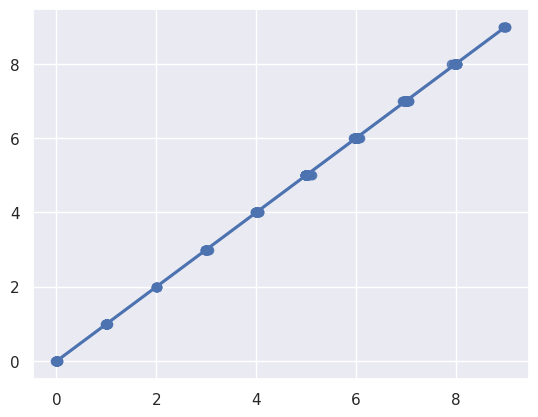

In [34]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

sns.regplot(x=test_preds, y=test_flower_counts)
plt.show()

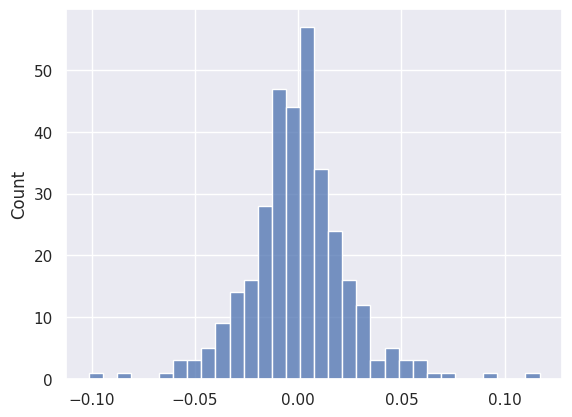

In [35]:
sns.histplot(x=errors)

In [36]:
import numpy as np

# Use the coefficient of variation of the differences between frames to provide a measure of "smoothness".
gt_diff = np.diff(test_flower_counts)
gt_smoothness = np.std(gt_diff) / np.abs(np.mean(gt_diff))
gt_smoothness

149.14087300267488

In [37]:
pred_diff = np.diff(test_preds)
pred_smoothness = np.std(pred_diff) / np.abs(np.mean(pred_diff))
pred_smoothness

138.44113

In [38]:
reps_diff = np.diff(test_image_reps_arr, axis=0)
reps_smoothness = np.std(reps_diff, axis=0) / np.abs(np.mean(reps_diff, axis=0))
np.mean(reps_smoothness)

3037.406